# Practice using an LLM as a Classifier

In [1]:
from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate
from datasets import load_dataset

from dotenv import load_dotenv

import json
import pandas as pd
import os

from azure.identity import (
    DefaultAzureCredential,
)

from azure.identity import AzureAuthorityHosts
from azure.keyvault.secrets import SecretClient

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

### Create your Azure OpenAI Resource and Key Vault

_If you have your resource from the last exercise, you don't need to complete the following steps._

Navigate to the [Azure Portal](https://portal.azure.com/#home) or [US Gov Azure Portal](https://portal.azure.us/#home) and login using your account. Next you're going to create an Azure OpenAI resource, create a new resource group and use any unique name for the resource's name.  
Once the resource is created, you need to open [Azure AI Foundry](https://ai.azure.com/) or [Azure OpenAI Studio](https://ai.azure.us/) to deploy the model. Navigate to deployments, press deploy model and select gpt-4o-mini.  Make sure to increase your rate limit, or tokens per minute (around 700k should be sufficient)

Once that is created, copy the key (Found under Resource Management > Keys and Endpoints) and create a new key vault. Assign the same resource group as your Azure OpenAI resource and again pick a unique name for the key vault name.  

Once the key vault is created, make a new secret with the API key.  

### Connect to Azure OpenAI
First, run `az login` in the terminal and login to your FedAIRS account.  
<br>
If you are using a Gov account:<br>
az cloud set --name AzureUSGovernment <br>
az login <br>
az account set --subscription="your subscription"<br>

If you are using a commercial account:<br>
az login <br>
az account set --subscription="your subscription"<br>
<br>
Two things are needed to connect to your Azure OpenAI resource
- Your API key
- Your Endpoint  
  
For the API Key, we are going to connect to the key vault we just made to insert the key. For this, you'll need to change the URL below to match your key vault's URL.  
Next, we will insert the endpoint URL from our Azure OpenAI resource.

Our `azure_client` is where we are calling the LLM and connecting to the model we deployed. Other parameters can be passed in, like timeout or max_retires.

Note: In the block below we inserted `credential = DefaultAzureCredential(authority=AzureAuthorityHosts.AZURE_GOVERNMENT)`. This is because when we use our FedAIRS account we are connected to the US Government cloud, rather than the regular commercial cloud.

In [2]:
load_dotenv()

credential = DefaultAzureCredential(authority=AzureAuthorityHosts.AZURE_GOVERNMENT)

secret_client = SecretClient(vault_url=os.getenv('KEY_VAULT_URL'), credential=credential)
deployment = os.getenv('DEPLOYMENT')
endpoint_url = os.getenv('AZURE_OPENAI_ENDPOINT')
api_version = os.getenv('API_VERSION')
api_key = secret_client.get_secret(os.getenv('SECRET_NAME')).value


azure_client = AzureChatOpenAI(
                api_key=api_key
                ,api_version=api_version
                ,azure_endpoint=endpoint_url
                ,deployment_name=deployment
                ,temperature=0
                ,max_tokens=4000
                ,model_kwargs={"response_format": {"type": "json_object"}}
)

### Lets Take a Look at the Data

We're going to pull data from [Hugging Face](https://huggingface.co/). Hugging Face is a platform and community that provides tools and resources for building, sharing, and collaborating on machine learning models and datasets. It supports a wide range of applications, including natural language processing, computer vision, and reinforcement learning, making it a valuable resource for developers and researchers.  

Generally, training datasets are split into two: training and testing. The training set is what is used to train the LLM, while the testing set is used for validation, to ensure the LLM can classify the data properly after being trained. For our purposes, we don't need to look at the training versus testing sets, but we will use the data as a whole.  

The [dataset](https://huggingface.co/datasets/SetFit/bbc-news) we are using is a collection of BBC headlines categorized into 5 types of articles:
* business
* sport
* tech
* entertainment


In [3]:
news_dataset=load_dataset("SetFit/bbc-news", split="train")
news = news_dataset.to_pandas()
news.drop(columns='label', inplace=True)
news.head()

Found cached dataset json (C:/Users/mislentz/.cache/huggingface/datasets/SetFit___json/SetFit--bbc-news-8edd71b4b12a4027/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


,text,label_text
0,wales want rugby league training wales could f...,sport
1,china aviation seeks rescue deal scandal-hit j...,business
2,rock band u2 break ticket record u2 have smash...,entertainment
3,markets signal brazilian recovery the brazilia...,business
4,tough rules for ringtone sellers firms that fl...,tech


Next, we will take a random sample of 100 rows to test against the LLM to see if it can classify the news titles properly

In [4]:
news_sample = news.sample(100).reset_index()

In the following block, we are setting up the prompt to query the LLM with the headlines. 

In [5]:
categories_prompt = PromptTemplate.from_template(

    template = '''
### Instructions:
Your job is to analyze the block of text and select the category that news article headline corresponds to.
Your selection must come from the category listed in the 'Categories' section.  Do answer with a category that is not in the category list.
Extract the key words that support your selection of a particular category.
Return your results in json.

### Categories
- business 
- entertainment
- politics
- sport
- tech 

### Article Headline:
{input}

### Return JSON:
{{
    "category": "<CategoryName>",
    "key_words": "<Notable words that led to the category selection>",
    "rationale": "<Explain why you selected the category>"
}}
'''
)

In the next few blocks, we are separating out the headlines so that we can run them through the LLM one at a time to be classified.

In [6]:
async def runChain(text_list, chain):
    texts = [{"input": text} for text in text_list]
    return await chain.abatch(texts, config={"max_concurrency": 15})

In [7]:
categories_chain = (
    categories_prompt
    | azure_client
    | StrOutputParser()
)

In [8]:
texts = [text for text in news_sample.text]

In [9]:
results = await runChain(texts, categories_chain)
news_sample["results"] = results

results_df = pd.json_normalize(news_sample.results.apply(json.loads))
final = pd.concat([news_sample, results_df], axis=1)

Below, we are making a dataframe of the actual categories of the headlines versus the prediction the LLM made.

In [10]:
final = final[['label_text','category','text','key_words','rationale']]
final = final.rename(columns={'category': 'prediction'})
final.head()

,label_text,prediction,text,key_words,rationale
0,business,business,nigeria to boost cocoa production the governme...,"boost cocoa production, development programme,...",The article discusses Nigeria's initiative to ...
1,tech,tech,eu software patent law faces axe the european ...,"software patent law, european parliament, hi-t...",The article discusses the rejection of a bill ...
2,sport,sport,holmes is hit by hamstring injury kelly holmes...,"hamstring injury, athletics championships, dou...","The article discusses an athlete, Kelly Holmes..."
3,tech,tech,new delay hits eu software laws a fresh delay ...,"eu software laws, computer-based inventions, p...",The article discusses new European Union regul...
4,tech,tech,hotspot users gain free net calls people using...,"wireless net hotspots, free phone calls, skype...",The article discusses advancements in technolo...


### Evalutating the Results
To evaluate the results of the LLM, we are going to use something called a _Confusion Matrix_. A Confusion Matrix is tool used to evaluate the performance of a classifier by comparing predicted labels with true labels. It consists of four components:

* True Positive (TP): Correctly predicted positive instances.
* False Positive (FP): Incorrectly predicted as positive.
* False Negative (FN): Incorrectly predicted as negative.
* True Negative (TN): Correctly predicted negative instances.  

The vertical axis corresponds to the actual category the headlines were given, while the horizontal axis shows the predicted categories. We can find the true positives along the diagonal of our confusion matrix. For example, 21 cases were classified as sports and were actually sports headlines, therse are true positives. The other boxes show us were there may have been errors. In the top row we fan see there are 3 headlines that were predicted as politics, but were actually business. These are false positives.  

There are a few other indicators we can measure and analyze:
* **Precision** is the ratio of true positive predictions to the total number of positive predictions (TP / (TP + FP)). It indicates how many of the predicted positive instances are actually positive.
* **Recall**, also known as sensitivity or true positive rate, is the ratio of true positive predictions to the total number of actual positive instances (TP / (TP + FN)). It measures how well the model is capturing all the positive instances.
* The **F1-score** is the harmonic mean of precision and recall, providing a single metric that balances both. It is calculated as 2 * (Precision * Recall) / (Precision + Recall). The F1-score is useful when you need to balance precision and recall.
* **Support** refers to the number of actual occurrences of each class in the dataset. It helps in understanding the distribution of the classes and can influence the interpretation of the other metrics.  

For more examples and information on what a confusion matrix is, check out [this article](https://towardsdatascience.com/visual-guide-to-the-confusion-matrix-bb63730c8eba).

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*9TDo041I1jDfkoRI09Zeog.gif"  width="450" height="350">

               precision    recall  f1-score   support

     business       0.83      0.77      0.80        13
entertainment       0.86      0.95      0.90        19
     politics       0.84      1.00      0.91        16
        sport       1.00      1.00      1.00        30
         tech       1.00      0.82      0.90        22

     accuracy                           0.92       100
    macro avg       0.91      0.91      0.90       100
 weighted avg       0.93      0.92      0.92       100



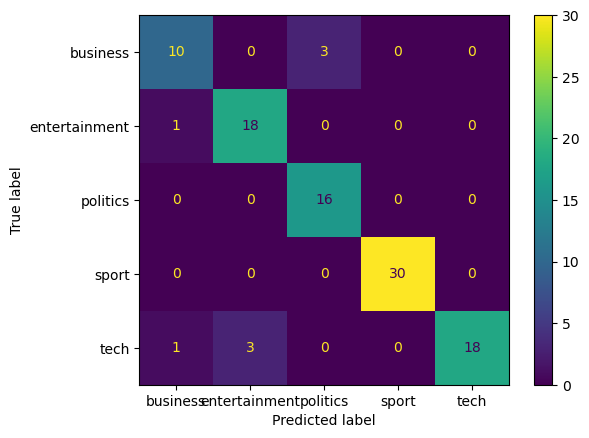

In [11]:
categories = ["business", "entertainment", "politics", "sport", "tech"]
y_true = final.label_text.apply(lambda x: categories.index(x))
y_pred = final.prediction.apply(lambda x: categories.index(x))

labels=categories

cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels).plot()

print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))